# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [1]:
#######  IMPORTS ###########
import os
import re
#import vtk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
import seaborn as sns

# import keras functions
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

from keras.models import model_from_json

/home/sousae/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def plot_regions_and_data(X, y, classifier,scaler,title):
    
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    levels = np.linspace(0.,1.,21)
    sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
    plt.colorbar(sc, label='Probability of Reversal')
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    X_set = scaler.inverse_transform(X)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','green'))(i), s=280, alpha=0.7)
    
    xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    plt.plot(xx,gammaCritical(xx),'b--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    plt.legend()
    
def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

Text(7.5,13,'$\\gamma_c$')

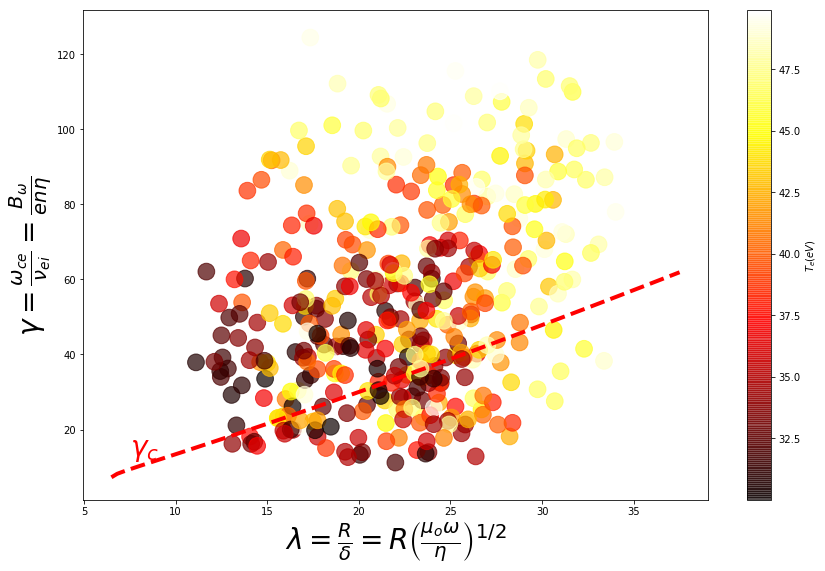

In [8]:
old = np.genfromtxt('frc_post_data.txt')

# Read in the new FRC simulations
new = np.genfromtxt('/home/sousae/frc_data/newFRCdata.txt')

# merge both new and old data
frc = np.concatenate((old,new),axis=0)

plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,2], cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,13.,r"$\gamma_c$",fontsize=28,color='red')

For each of the points in the scatter plot an Apollo simulations was run.

In [9]:
#time = 51
#component = 0

# get a list of all sub-directories in thedir
#thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
#subdirs = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
#if '.ipynb_checkpoints' in subdirs: subdirs.remove('.ipynb_checkpoints') ### I get this weird sting in there somehow
    
#reader = vtk.vtkXMLUnstructuredGridReader()

# this function extracts the RMF frequency, RMF field magnitude, and the electron temperature at initialization
#def getSimulationParameters(filename):
#    f=open(filename)
#    lines = f.readlines()
#    om = re.findall("\d+\.\d+",lines[2])
#    Bo = re.findall("\d+\.\d+",lines[3])
#    Te = re.findall("\d+\.\d+",lines[4])
    
#    return float(om[0]), float(Bo[0]), float(Te[0])
    
#################### this is used to get the dimensions of the dataset per output file #####
#d = np.loadtxt(thedir+'/simulation_values.txt')
#folder = 'gammaOverGamma_crit_0.804947683677'
#filename = os.path.join(thedir,folder)+'/frc2d_2Fluid_000.vtu'
#reader = vtk.vtkXMLUnstructuredGridReader()
#reader.SetFileName(filename)
#reader.Update()
#size = len( vtk_to_numpy( reader.GetOutput().GetPointData().GetArray(component) ) )
############################################################################################

#dataB = np.zeros((size,time))
#dataR = np.zeros((size,time))
#minBz= np.zeros(time)

#frc = np.zeros((len(subdirs),12))

# Loop over all sample test cases
#for s in range(len(subdirs)):
    # get the values of omega, b_omega, and Te for this sample
#    frc[s,0], frc[s,1], frc[s,2] = getSimulationParameters(os.path.join(thedir,subdirs[s])+'/frc2d.pin')
    #calculate gamma, lambda and gamma/gammaCritical
#    frc[s,4], frc[s,3]   = calRatio(frc[s,0], frc[s,1], frc[s,2])
#    frc[s,5] = frc[s,4]/gammaCritical(frc[s,3])
    
    # loop over all time slices
#    for k in range(time):
#        filename = os.path.join(thedir,subdirs[s])+'/frc2d_2Fluid_'+str('%03d' % k)+'.vtu'
#        reader.SetFileName(filename)
#        reader.Update()
#        dataB[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(15)) # Bz
#        dataR[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(0)) # electron density
#        minBz[k]  = min(dataB[:,k])
        
    ### Do a SVD
#    U, sB, V = np.linalg.svd(dataB, full_matrices=False)
#    U, sR, V = np.linalg.svd(dataR, full_matrices=False)
    
    ### Get the first singular value for Bz SVD
#    frc[s,6] = sB[0]
#    frc[s,7] = sB[0]/sB.sum()
    
    ### Get the first singular value for rho_e SVD
#    frc[s,8] = sR[0]
#    frc[s,9] = sR[0]/sR.sum()
    
#    frc[s,10] = dataB.min()
#    frc[s,11] = (1. if dataB.min() < 0. else 0.)
#plt.figure(figsize=(14,9))
#plt.subplot(421), plt.plot(s/sum(s),'bo', markersize=12)
#plt.subplot(423), plt.plot(U[:,0],'b',lw=2)
#plt.subplot(425), plt.plot(U[:,1],'r',lw=2)
#plt.subplot(427), plt.plot(U[:,2],'g',lw=2)

#plt.subplot(422), plt.plot(minBz,lw=2)
#plt.subplot(422), plt.plot(plasmaFreqe,'r',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqi,'g',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqp,'m',lw=2)
#plt.subplot(424), plt.plot(V[0,:],'b',lw=2)
#plt.subplot(426), plt.plot(V[1,:],'r',lw=2)
#plt.subplot(428), plt.plot(V[2,:],'g',lw=2)
#np.savetxt(os.path.join(thedir,subdirs[s])+'/frc_testSamplesData.txt', frc)
#print('Done.')

Text(7.5,13,'$\\gamma_c$')

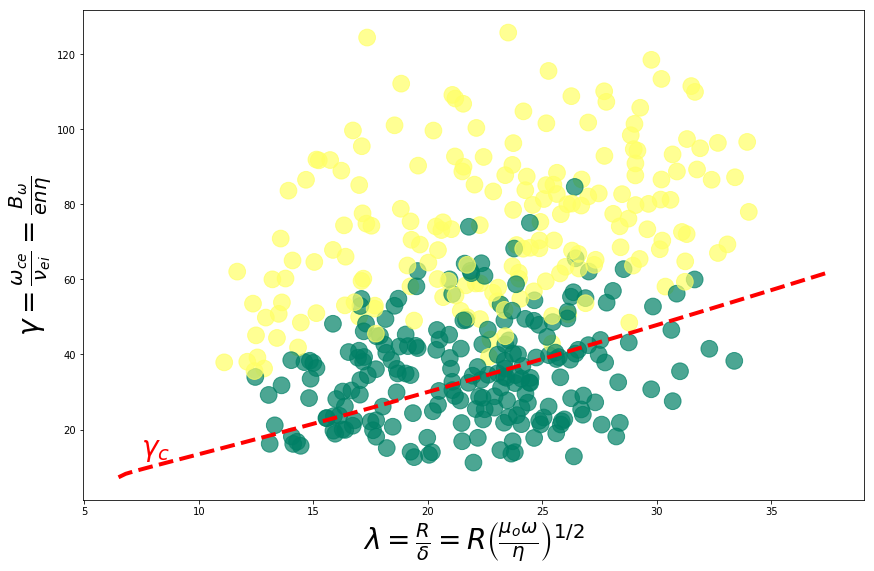

In [11]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap="summer", alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
plt.plot(xx,gammaCritical(xx),'r--',lw=4.)
plt.text(7.5,13.,r"$\gamma_c$",fontsize=28,color='red')

In [12]:
df = pd.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

df["Bz_negative"] = df['reversal'].astype('category')

In [13]:
#fig, ax = plt.subplots(figsize=(14,9))
#sns.lmplot(x= 'lambda', y= 'gamma', data=df, hue='Bz_negative', palette='Set1', size=280)

The prediction pattern is complex, therefore a deep learning neural network will be developed in an attempt to predict the test cases reversal.

In [14]:
# setup need variables
predictors = frc[:,3:5]
target = to_categorical(frc[:,11])[:,1]


n_cols = predictors.shape[1]

# scale the predictors
scaler = StandardScaler()
scaler.fit(predictors)
predictors_scaled = scaler.transform(predictors)

In [15]:
# load json and create model
json_file = open('neuralNetModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("neuralNetModelWeights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [16]:
X_set, y_set = predictors_scaled, target
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

In [17]:
Areas = loaded_model.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

In [18]:
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
X1 = Xit[:,0].reshape(X1.shape)
X2 = Xit[:,1].reshape(X2.shape)

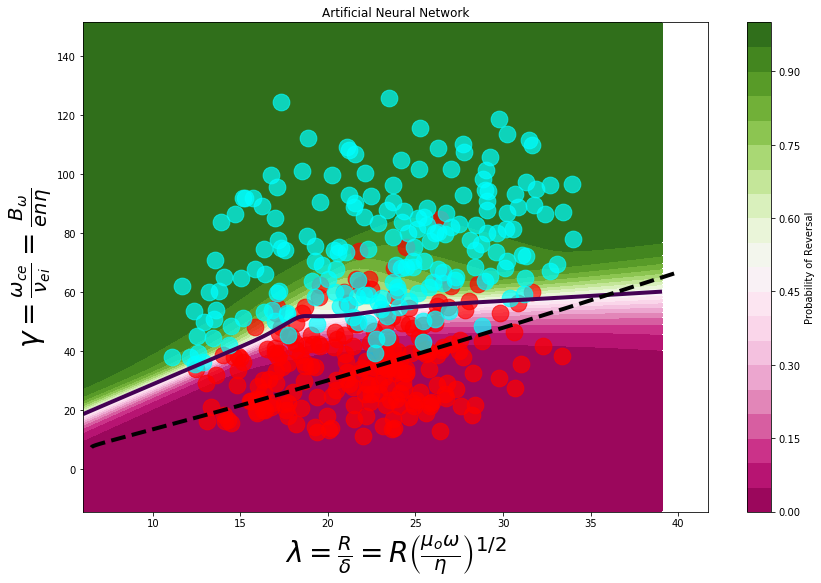

In [20]:
plt.figure(figsize=(14,9))
levels = np.linspace(0.,1.,21)
sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
plt.colorbar(sc, label='Probability of Reversal')

X_set = scaler.inverse_transform(predictors_scaled)
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
    
plt.contour(X1,X2,Areas,[0.5],linewidths=4)
#xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
xx = np.linspace(6.5, 40., 1000)
plt.plot(xx,gammaCritical(xx),'k--',lw=4.)

plt.title("Artificial Neural Network")
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.legend()
plt.savefig("deepLearningFRC2.png",dpi=300)

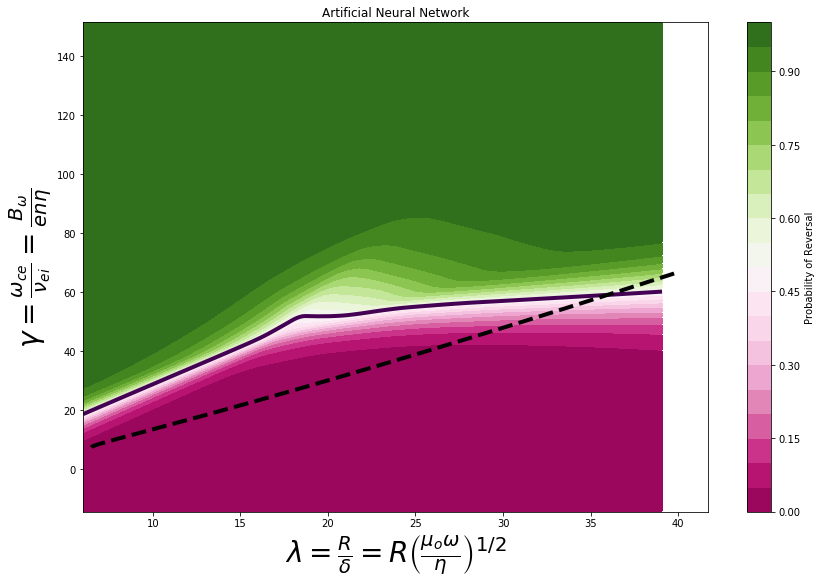

In [21]:
plt.figure(figsize=(14,9))
levels = np.linspace(0.,1.,21)
sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
plt.colorbar(sc, label='Probability of Reversal')
plt.contour(X1,X2,Areas,[0.5],linewidths=4)
    
#xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
xx = np.linspace(6.5, 40., 1000)
plt.plot(xx,gammaCritical(xx),'k--',lw=4.)

plt.title("Artificial Neural Network")
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.legend()
plt.savefig("deepLearningFRC2_areas.png",dpi=300)

In [33]:
Above=df[df['gammaOverCrit']>1]

In [34]:
Above.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 398
Data columns (total 13 columns):
omega            299 non-null float64
Bomega           299 non-null float64
Te               299 non-null float64
lambda           299 non-null float64
gamma            299 non-null float64
gammaOverCrit    299 non-null float64
svd_bz           299 non-null float64
svd_bz_per       299 non-null float64
svd_rho          299 non-null float64
svd_rho_perc     299 non-null float64
minBz            299 non-null float64
reversal         299 non-null float64
Bz_negative      299 non-null category
dtypes: category(1), float64(12)
memory usage: 30.8 KB


In [35]:
new=Above[Above['reversal']==1]

In [36]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 398
Data columns (total 13 columns):
omega            186 non-null float64
Bomega           186 non-null float64
Te               186 non-null float64
lambda           186 non-null float64
gamma            186 non-null float64
gammaOverCrit    186 non-null float64
svd_bz           186 non-null float64
svd_bz_per       186 non-null float64
svd_rho          186 non-null float64
svd_rho_perc     186 non-null float64
minBz            186 non-null float64
reversal         186 non-null float64
Bz_negative      186 non-null category
dtypes: category(1), float64(12)
memory usage: 19.2 KB


In [37]:
186./320.

0.58125